### Result of Uniform Singapore Energy/ElectrictyPrice (USEP) LSTM Forecasting  Model (last 3 day in test data)

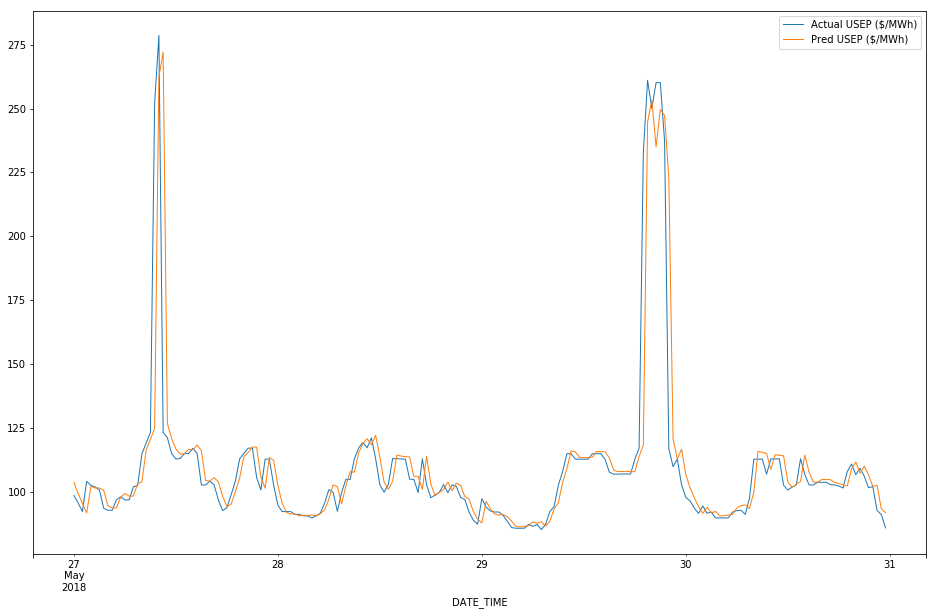

In [17]:
result_df.iloc[-(48*4):,:].plot(kind='line', figsize=(16,10) , lw=1); #style=['o','rx']
plt.show()

### Steps
    1.Load collated data
    2.Set ML Modelling setting
    3.Create rolling window features
    4.Create Training & Testing Cube
    5.Train Model
    6.Save Model
    7.Test Model error
    8.Plot Predicted & Actual Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

C:\Users\ch661nc\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def gcd(x, y):
    "greatest common denominator"
    while y != 0:
        (x, y) = (y, x % y)
    return x

In [3]:
#input file name
min_usep_price = -150
csv_file_name ='USEP_CONCAT_DATA_2003_2018MAY.csv' #'USEP_CONCAT_DATA.csv'

df = pd.read_csv(csv_file_name, parse_dates=['DATE'], low_memory=False)
df['DATE_TIME'] = df['DATE'] + (df['PERIOD']-1)*pd.Timedelta(30,unit='m')
df['DAY'] = df['DATE'].dt.day
df['MONTH'] = df['DATE'].dt.month
df = df.set_index('DATE_TIME')
df = df.drop(['DATE'],axis=1)
df['DEMAND (MW)'] = np.log(df['DEMAND (MW)'])#np.cbrt(df['DEMAND (MW)'])
df['USEP ($/MWh)']= np.log(df['USEP ($/MWh)']-min_usep_price)#np.cbrt(df['USEP ($/MWh)'].clip(lower = df['USEP ($/MWh)'].quantile(.0001), upper = df['USEP ($/MWh)'].quantile(1-.0001)))
df = df.dropna()
#df = df.iloc[47:,:]
df.head()

,DEMAND (MW),PERIOD,USEP ($/MWh),DAY,MONTH
DATE_TIME,,,,,
2003-01-01 00:00:00,8.092219,1,5.381187,1,1
2003-01-01 00:30:00,8.073639,2,5.380819,1,1
2003-01-01 01:00:00,8.053079,3,5.353374,1,1
2003-01-01 01:30:00,8.035213,4,5.328992,1,1
2003-01-01 02:00:00,8.020500,5,5.328070,1,1


In [4]:
df.describe(include=['float'])

,DEMAND (MW),USEP ($/MWh)
count,270192.000000,270192.000000
mean,8.481756,5.617222
std,0.182798,0.219308
min,7.837793,4.941071
25%,8.354381,5.454466
50%,8.493617,5.595529
75%,8.621202,5.735443
max,8.863710,8.444622


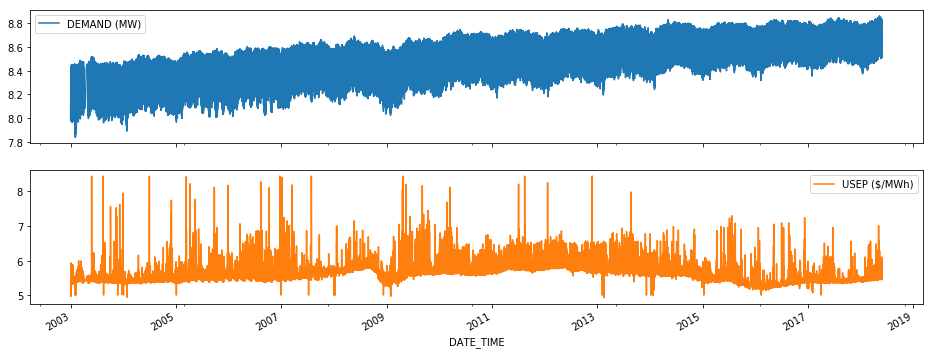

In [5]:
# plot data
df.select_dtypes(include=['float']).plot.line(subplots=True, figsize=(16,6), legend=True,)
#[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

### Modelling Setting

In [6]:
## Modeling settings
input_lags = 48
output_period = 1
predictor_cols = ['USEP ($/MWh)'] # fill in required order
n_features = 5
n_train_hours = round(48*30*12*11) #round(frac_train_dataset*n_data_points)#frac_train_dataset = 0.8
batch_samp_size = gcd(n_train_hours,df.shape[0]-n_train_hours-input_lags)#round(0.01*train_X.shape[0])
print('batch_size:',batch_samp_size)
print('fration of data used for training:',100.0*n_train_hours/(df.shape[0]-input_lags))
fBestModel = 'best_model_stateful_48_single_layer.h5'
epoch_size = 20

batch_size: 576
fration of data used for training: 70.36247334754798


In [7]:
## Reorder columns
#print(df.columns)
#np.array(predictor_cols)
reorder_cols = predictor_cols + df.columns[~np.isin(df.columns, predictor_cols)].tolist()
df = df[reorder_cols]
df.head()

,USEP ($/MWh),DEMAND (MW),PERIOD,DAY,MONTH
DATE_TIME,,,,,
2003-01-01 00:00:00,5.381187,8.092219,1,1,1
2003-01-01 00:30:00,5.380819,8.073639,2,1,1
2003-01-01 01:00:00,5.353374,8.053079,3,1,1
2003-01-01 01:30:00,5.328992,8.035213,4,1,1
2003-01-01 02:00:00,5.328070,8.020500,5,1,1


In [8]:
## standardise data
# values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])# automate this
# ensure all data is float
# values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)
scaled_df  = pd.DataFrame(scaled,columns=df.columns,index=df.index)
scaled_df.describe()
#scaled_df.describe()

,USEP ($/MWh),DEMAND (MW),PERIOD,DAY,MONTH
count,2.701920e+05,2.701920e+05,2.701920e+05,2.701920e+05,2.701920e+05
mean,6.905251e-15,4.402071e-15,-5.664770e-17,2.208689e-15,2.532912e-14
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.083119e+00,-3.522819e+00,-1.696335e+00,-1.673675e+00,-1.572161e+00
25%,-7.421368e-01,-6.968127e-01,-8.481673e-01,-8.780645e-01,-9.944336e-01
50%,-9.891766e-02,6.488535e-02,0.000000e+00,3.120446e-02,-1.278425e-01
75%,5.390618e-01,7.628409e-01,8.481673e-01,8.268148e-01,7.387485e-01
max,1.289240e+01,2.089487e+00,1.696335e+00,1.736084e+00,1.605340e+00


In [9]:
def ts_to_prediction_dataset(data,n_lags=1, n_preds=1,target_cols=[], dropnan=True):
    """
    convert time series to prediction training dataset 
    """
    #data = pd.read_csv('pollution.csv', header=0, index_col=0)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    #n_lags=3
    #n_preds=1; 
    dropnan=True
    cols, names = list(), list()
    # print(data.columns)
    for i in range(n_lags,0,-1):
        cols.append(df.shift(i))
        #names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        names += [('%s(t-%d)' % (j, i)) for j in data.columns]
    # print(names)
    if len(target_cols)==0:
        target_cols = data.columns 
    
    for i in range(0, n_preds):
        cols.append(df[target_cols].shift(-i))
        if i == 0:
            #names += [('%s(t)' % (j)) for j in data.columns]
            names += [('%s(t)' % (j)) for j in target_cols]
        else:
            #names += [('%s(t+%d)' % (j, i)) for j in data.columns]
            names += [('%s(t+%d)' % (j, i)) for j in target_cols]

    # put it all together
    df_ts_concat = pd.concat(cols, axis=1)
    df_ts_concat.columns = names

    # drop rows with NaN values
    if dropnan:
        df_ts_concat.dropna(inplace=True)

    return df_ts_concat

In [10]:
# frame as supervised learning
reframed = ts_to_prediction_dataset(scaled_df, input_lags,output_period,predictor_cols)
#reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
# for i in range(0, output_steps):
#     if i == 0:
#         drop_output_names = [('%s(t)' % (j)) for j in scaled_df.columns if j not in predictor_cols]
#     else:
#         names += [('%s(t+%d)' % (j, i)) for j in scaled_df.columns if j not in predictor_cols]
# print(names)
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,USEP ($/MWh)(t-48),DEMAND (MW)(t-48),PERIOD(t-48),DAY(t-48),MONTH(t-48),USEP ($/MWh)(t-47),DEMAND (MW)(t-47),PERIOD(t-47),DAY(t-47),MONTH(t-47),...,DEMAND (MW)(t-2),PERIOD(t-2),DAY(t-2),MONTH(t-2),USEP ($/MWh)(t-1),DEMAND (MW)(t-1),PERIOD(t-1),DAY(t-1),MONTH(t-1),USEP ($/MWh)(t)
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2003-01-02 00:00:00,-1.076276,-2.130977,-1.696335,-1.673675,-1.572161,-1.077955,-2.232621,-1.624150,-1.673675,-1.572161,...,-1.887929,1.624150,-1.673675,-1.572161,-0.934946,-2.027302,1.696335,-1.673675,-1.572161,-1.073339
2003-01-02 00:30:00,-1.077955,-2.232621,-1.624150,-1.673675,-1.572161,-1.203099,-2.345091,-1.551966,-1.673675,-1.572161,...,-2.027302,1.696335,-1.673675,-1.572161,-1.073339,-2.179683,-1.696335,-1.560016,-1.572161,-1.078375
2003-01-02 01:00:00,-1.203099,-2.345091,-1.551966,-1.673675,-1.572161,-1.314274,-2.442830,-1.479781,-1.673675,-1.572161,...,-2.179683,-1.696335,-1.560016,-1.572161,-1.078375,-2.300340,-1.624150,-1.560016,-1.572161,-1.121408
2003-01-02 01:30:00,-1.314274,-2.442830,-1.479781,-1.673675,-1.572161,-1.318477,-2.523316,-1.407597,-1.673675,-1.572161,...,-2.300340,-1.624150,-1.560016,-1.572161,-1.121408,-2.404757,-1.551966,-1.560016,-1.572161,-1.078585
2003-01-02 02:00:00,-1.318477,-2.523316,-1.407597,-1.673675,-1.572161,-1.318477,-2.590333,-1.335412,-1.673675,-1.572161,...,-2.404757,-1.551966,-1.560016,-1.572161,-1.078585,-2.493509,-1.479781,-1.560016,-1.572161,-1.121620


### Split Train Test Data

In [11]:
# split into train and test sets
values = reframed.values

n_data_points = scaled_df.shape[0]

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = input_lags * n_features
n_predictor_col = len(predictor_cols)*output_period

train_X, train_y = train[:, :n_obs], train[:, -n_predictor_col]
test_X, test_y = test[:, :n_obs], test[:, -n_predictor_col]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], input_lags, n_features))
test_X = test_X.reshape((test_X.shape[0], input_lags, n_features))
print(train_X.shape,test_X.shape)

(190080, 240) (190080,) (80064, 240) (80064,)
(190080, 48, 5) (80064, 48, 5)


### Model Training

In [ ]:
model = Sequential()
model.add(LSTM(48, batch_input_shape=(batch_samp_size, train_X.shape[1], train_X.shape[2]),
               stateful=True, return_sequences=False))
model.add(Dropout(0.2))
#model.add(LSTM(24, batch_input_shape=(batch_samp_size, train_X.shape[1], train_X.shape[2]), stateful=False, return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))


model.compile(loss='mae', optimizer='adam')
model.summary()
    
# summarize performance of the model
# # design network
# model = Sequential()
# model.add(LSTM(15, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(15,return_sequences=False))
# model.add(Dropout(0.2))
# #model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
# #model.add(Dropout(0.1))
# #model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))
# #model.add(Dropout(0.1))
# #model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))

# model.add(Dense(1,activation='linear'))
# model.compile(loss='mae', optimizer='Nadam')
# model.summary()

In [ ]:
#new_model = load_model(fBestModel)
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)
history = []
# fit network
# history = model.fit(train_X, train_y, epochs=80, batch_size=batch_samp_size,
#                     validation_data=(test_X, test_y), verbose=2, shuffle=False,callbacks=[best_model])
for i in range(epoch_size):
    history.append(model.fit(train_X, train_y, epochs=1, batch_size=batch_samp_size,validation_data=(test_X, test_y),
              verbose=2, shuffle=False, callbacks=[best_model]))
    model.reset_states()

In [ ]:
# plot history
loss_train,loss_test =[],[]
for i in range(epoch_size):
    #loss_train.append(history[i].history['loss'])
    loss_train = loss_train + history[i].history['loss']
    loss_test = loss_test + history[i].history['val_loss']
plt.plot(loss_train, label='train')
plt.plot(loss_test, label='test')
plt.legend()
plt.show()

In [12]:
model = load_model(fBestModel)
yhat = model.predict(test_X,batch_size=batch_samp_size, verbose=0)
test_X = test_X.reshape((test_X.shape[0], n_obs))

### Model Testing

In [13]:
# invert scaling for forecast
inv_yhat = np.concatenate(( yhat,test_X[:, :n_features-1]), axis=1) 
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:n_predictor_col]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate(( test_y,test_X[:, :n_features-1]), axis=1) 
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:n_predictor_col]
# tranformation of data
inv_y = np.exp(inv_y)+min_usep_price
inv_yhat = np.exp(inv_yhat)+min_usep_price
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae_val = np.mean(np.abs(inv_y - inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae_val)

Test RMSE: 23.188
Test MAE: 6.460


In [15]:
result_df = pd.DataFrame(data=np.hstack((inv_y, inv_yhat)),
                         columns=["Actual %s" % i for i in predictor_cols] + ["Pred %s" % i for i in predictor_cols],
                         index=reframed.index[n_train_hours:])
result_df.head()

,Actual USEP ($/MWh),Pred USEP ($/MWh)
DATE_TIME,,
2013-11-05 00:00:00,170.67,131.493153
2013-11-05 00:30:00,171.61,169.775061
2013-11-05 01:00:00,161.80,166.529369
2013-11-05 01:30:00,152.17,156.330060
2013-11-05 02:00:00,151.37,148.337400


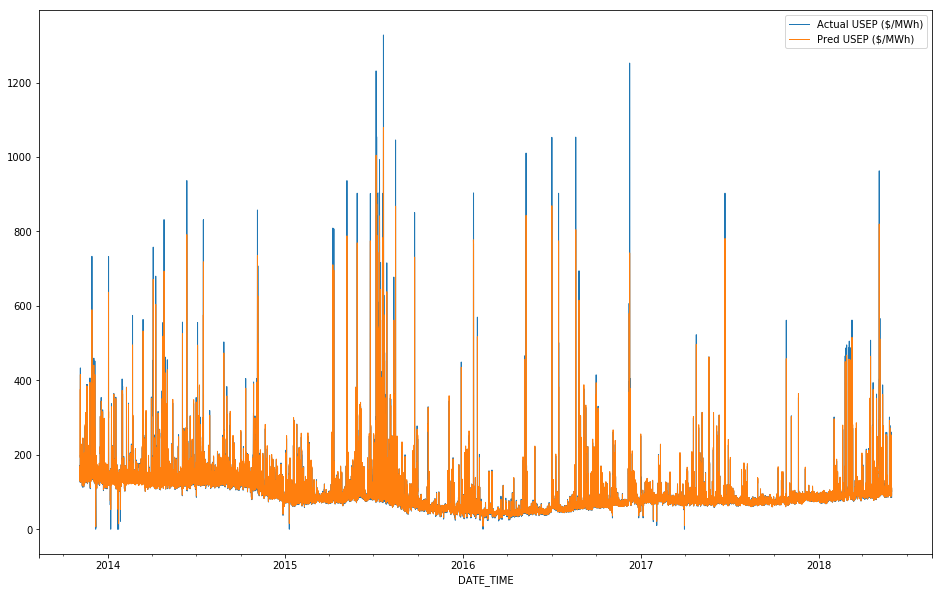

In [16]:
result_df.iloc[:,:].plot(kind='line', figsize=(16,10) , lw=1); #style=['o','rx']
plt.show()

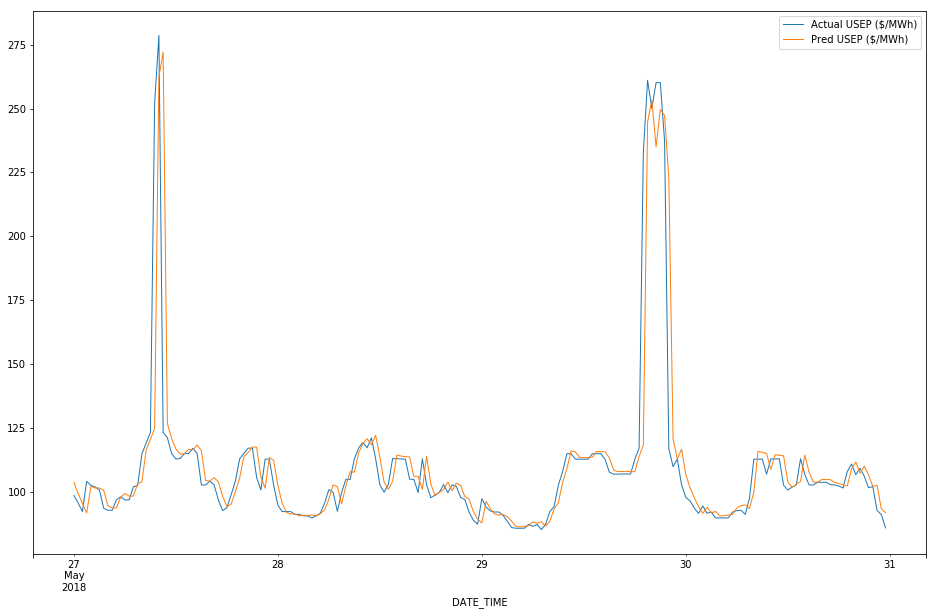

In [17]:
result_df.iloc[-(48*4):,:].plot(kind='line', figsize=(16,10) , lw=1); #style=['o','rx']
plt.show()

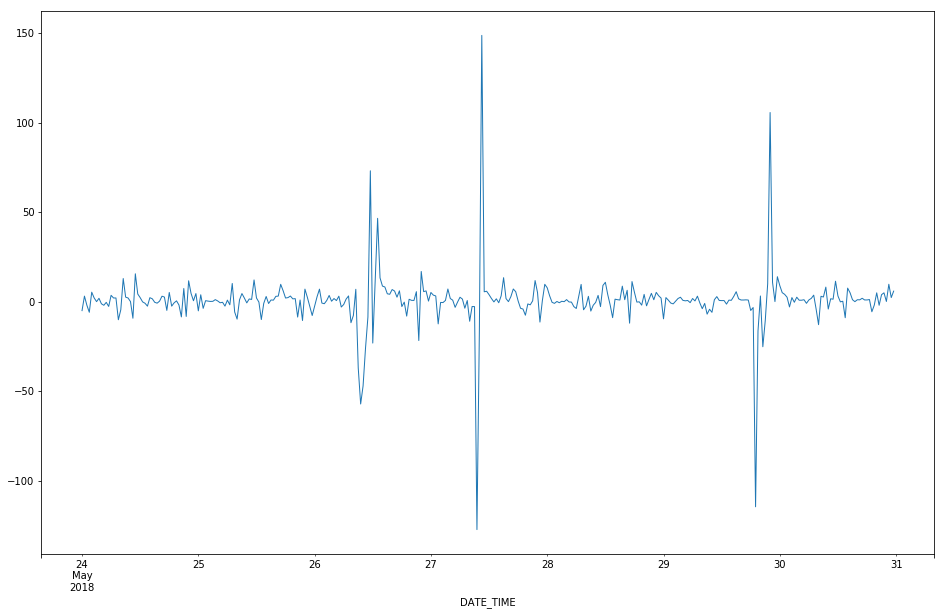

In [18]:
result_df.diff(axis=1).iloc[-(48*7):,1].plot(kind='line', figsize=(16,10) , lw=1); #style=['o','rx']
plt.show()